<a href="https://colab.research.google.com/github/John-Akech/summative-trial/blob/master/Summative_Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install --upgrade xgboost scikit-learn imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import joblib
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [2]:
# Load the dataset
url = "/content/flood.csv"
data = pd.read_csv(url)

In [3]:
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
data.head()

First 5 rows of the dataset:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [4]:
# Chek the size
print("\nDataset shape:", data.shape)


Dataset shape: (50000, 21)


In [5]:
#Display the data info
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  Coa

In [6]:
# Check for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())


Missing values in the dataset:
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


In [7]:
# Display the duplicates
print("\nNumber of duplicates in the dataset:", data.duplicated().sum())
data = data.drop_duplicates()


Number of duplicates in the dataset: 0


In [8]:
# Basic statistics
print("\nBasic statistics of the dataset:")
print(data.describe())


Basic statistics of the dataset:
       MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
count      50000.000000        50000.000000      50000.00000   50000.000000   
mean           4.991480            4.984100          5.01594       5.008480   
std            2.236834            2.246488          2.23131       2.222743   
min            0.000000            0.000000          0.00000       0.000000   
25%            3.000000            3.000000          3.00000       3.000000   
50%            5.000000            5.000000          5.00000       5.000000   
75%            6.000000            6.000000          6.00000       6.000000   
max           16.000000           18.000000         16.00000      17.000000   

       Urbanization  ClimateChange  DamsQuality     Siltation  \
count  50000.000000   50000.000000  50000.00000  50000.000000   
mean       4.989060       4.988340      5.01536      4.988600   
std        2.243159       2.226761      2.24500      2.2326

In [9]:
# Drop irrelevant features
features_to_drop = ['DamsQuality', 'CoastalVulnerability', 'AgriculturalPractices', 'Siltation', 'Watersheds', 'PoliticalFactors']
data = data.drop(features_to_drop, axis=1)

In [10]:
data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,Landslides,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,FloodProbability
0,3,8,6,6,4,4,2,5,10,4,3,4,3,2,0.450
1,8,4,5,7,7,9,4,6,9,6,1,1,9,1,0.475
2,3,10,4,1,7,5,9,2,7,4,6,1,8,3,0.515
3,4,4,2,7,3,4,4,9,4,6,8,8,6,6,0.520
4,3,7,5,2,5,8,5,7,7,5,3,4,4,3,0.475


In [11]:
# Check size
print("\nDataset shape after dropping irrelevant features:", data.shape)


Dataset shape after dropping irrelevant features: (50000, 15)


In [12]:
# Convert FloodProbability into classes
data['FloodRisk'] = pd.cut(data['FloodProbability'], bins=[0, 0.4, 0.6, 1], labels=['Low', 'Medium', 'High'])

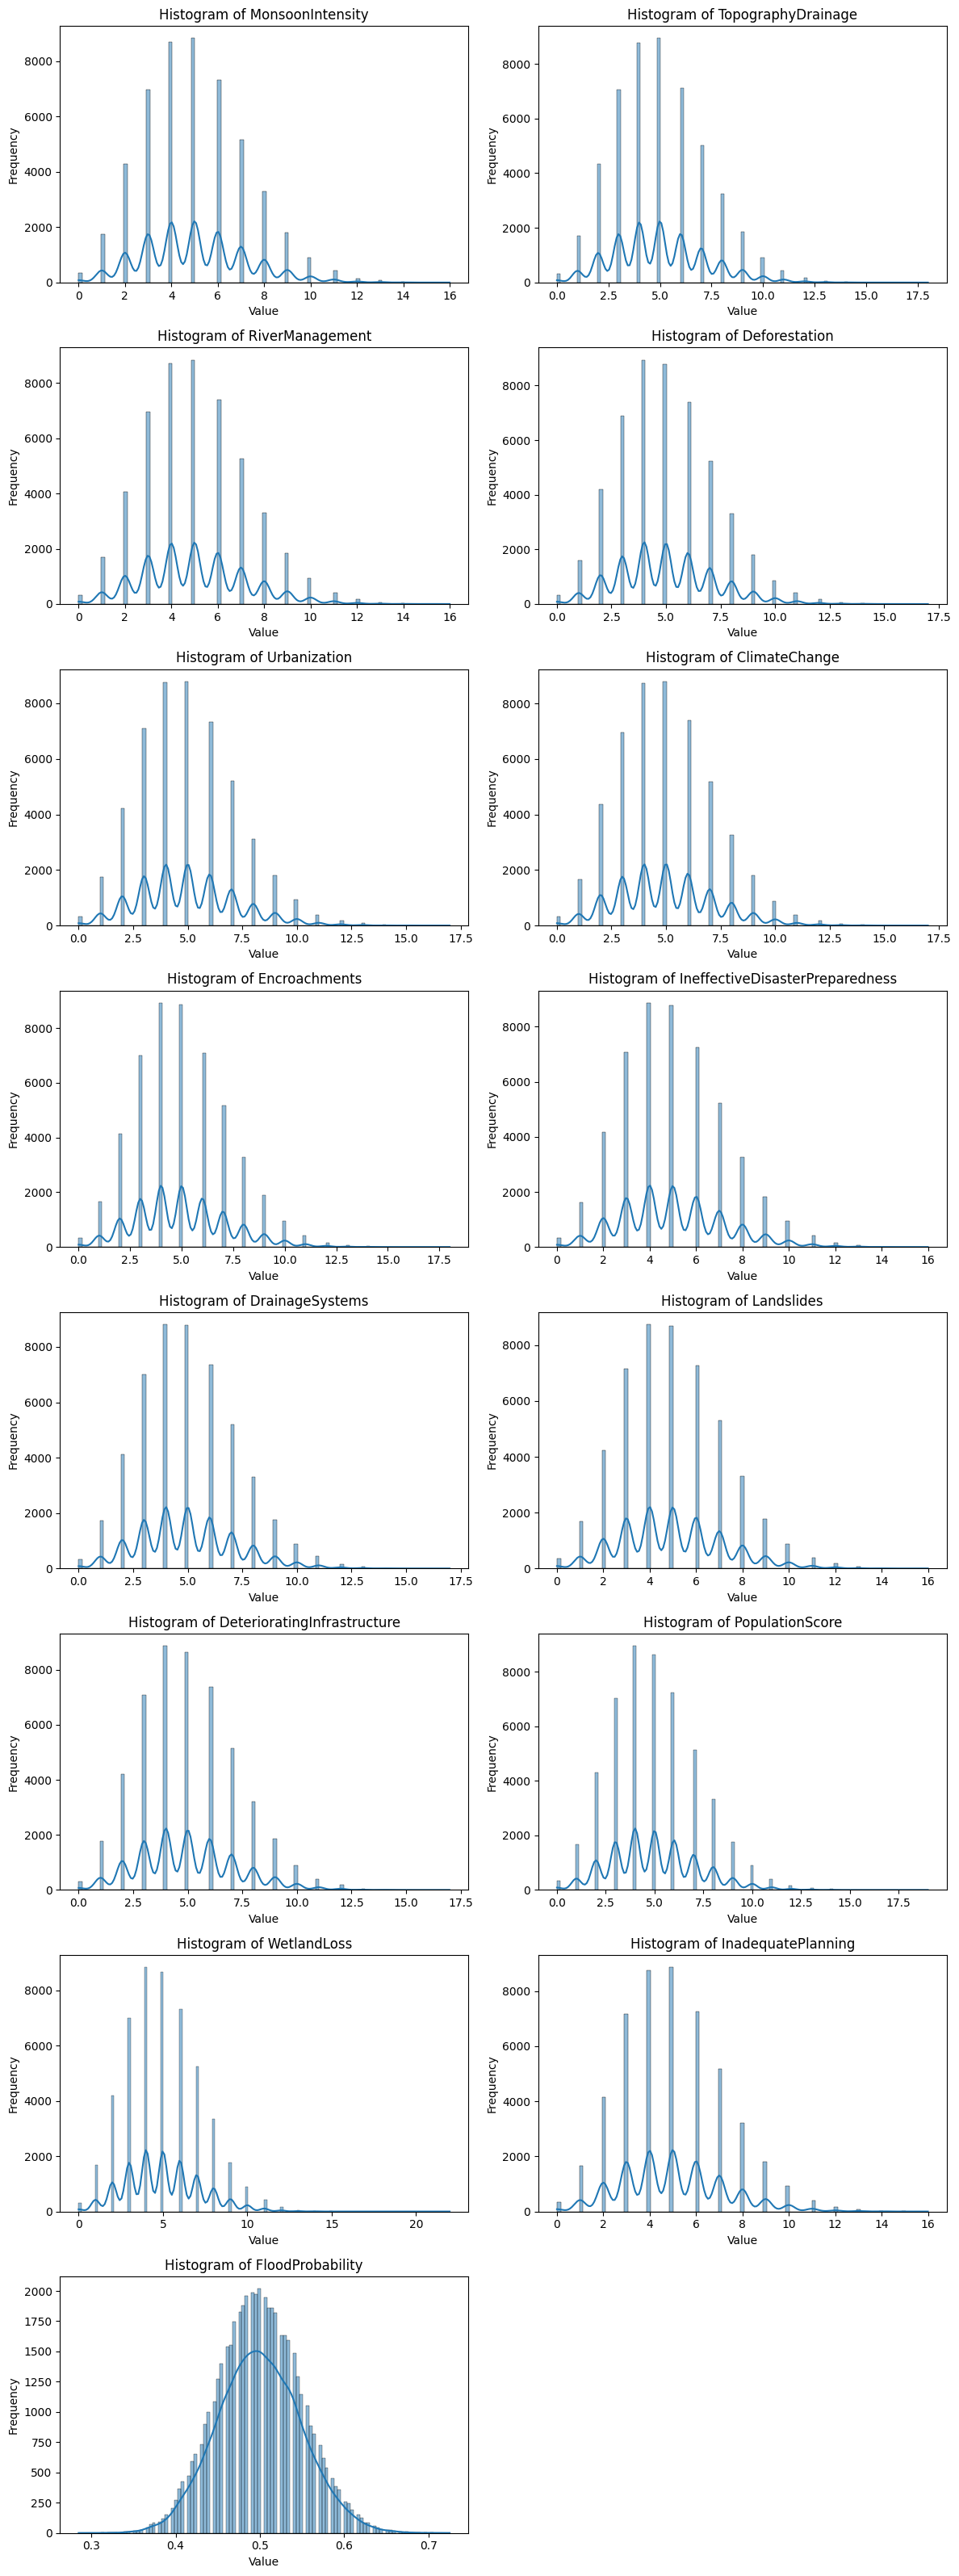

In [13]:
# Plot histograms for numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
n_cols = 2
n_rows = int(np.ceil(len(numeric_columns) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    ax = axes[i]
    sns.histplot(data[column], kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Remove any unused subplots
for ax in axes[len(numeric_columns):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [14]:
# Encode categorical columns (e.g., 'FloodRisk')
data_encoded = data.copy()
data_encoded['FloodRisk'] = data_encoded['FloodRisk'].map({'Low': 0, 'Medium': 1, 'High': 2})

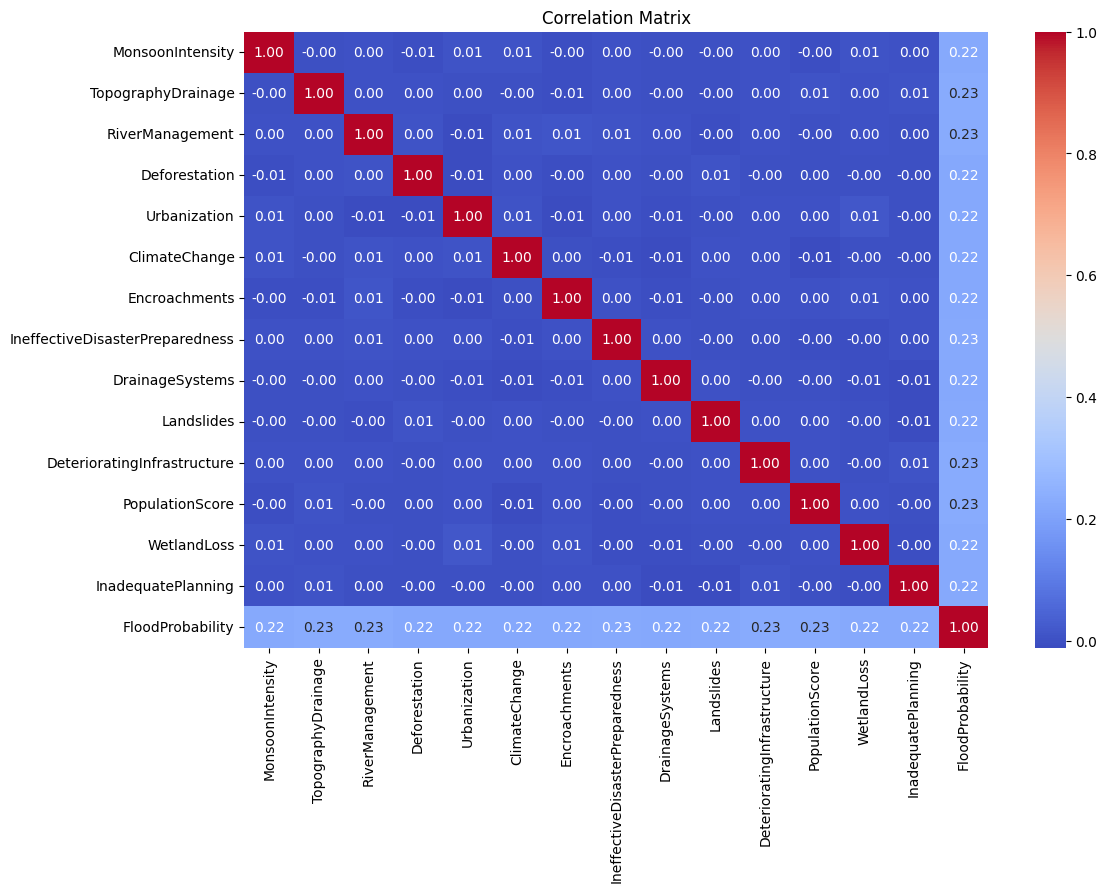

In [15]:
# Correlation matrix (only for numeric columns)
plt.figure(figsize=(12, 8))
correlation = data_encoded.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Split the data into features and target
X = data.drop(['FloodRisk', 'FloodProbability'], axis=1)
y = data['FloodRisk']

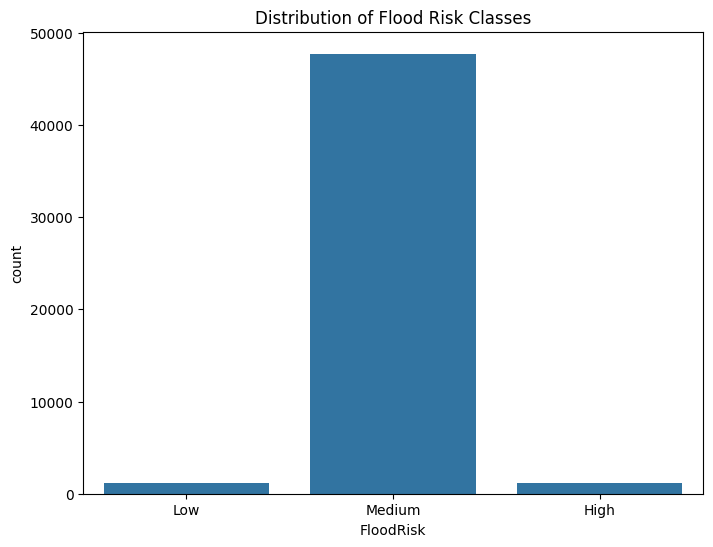

In [17]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='FloodRisk', data=data)
plt.title('Distribution of Flood Risk Classes')
plt.show()

In [64]:
# Encode the target variable into numerical values
le = LabelEncoder()
y = le.fit_transform(y)

In [65]:
# Split the data into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [66]:
# Check for Imbalanced Data
print("\nDistribution of Flood Risk Classes:")
print(data['FloodRisk'].value_counts())


Distribution of Flood Risk Classes:
FloodRisk
Medium    44444
Low        1094
High        749
Name: count, dtype: int64


In [67]:
# Address Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE

In [22]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [23]:
# Check the distribution after resampling
print("\nDistribution of Flood Risk Classes after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Distribution of Flood Risk Classes after SMOTE:
2    28639
1    28639
0    28639
Name: count, dtype: int64


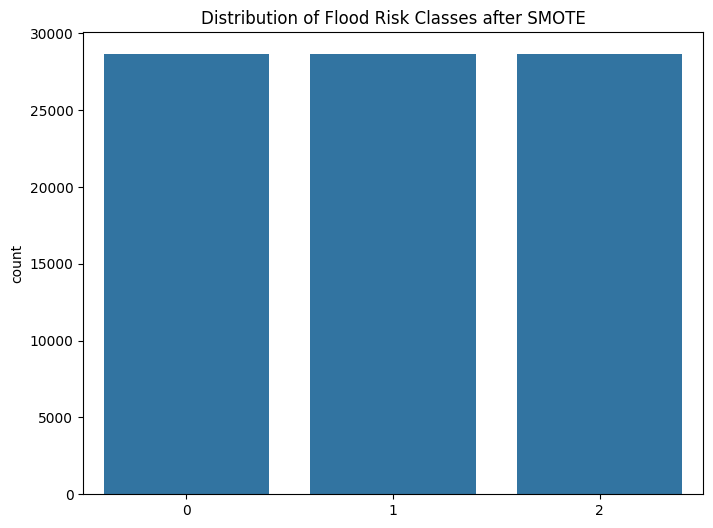

In [24]:
# Visualize the resampled distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled)
plt.title('Distribution of Flood Risk Classes after SMOTE')
plt.show()

In [25]:
# Check for Outliers
numeric_columns = data.select_dtypes(include=[np.number]).columns

In [26]:
# Calculate the number of rows and columns for subplots
n_cols = 3  # You can set this to any number you prefer
n_rows = int(np.ceil(len(numeric_columns) / n_cols))

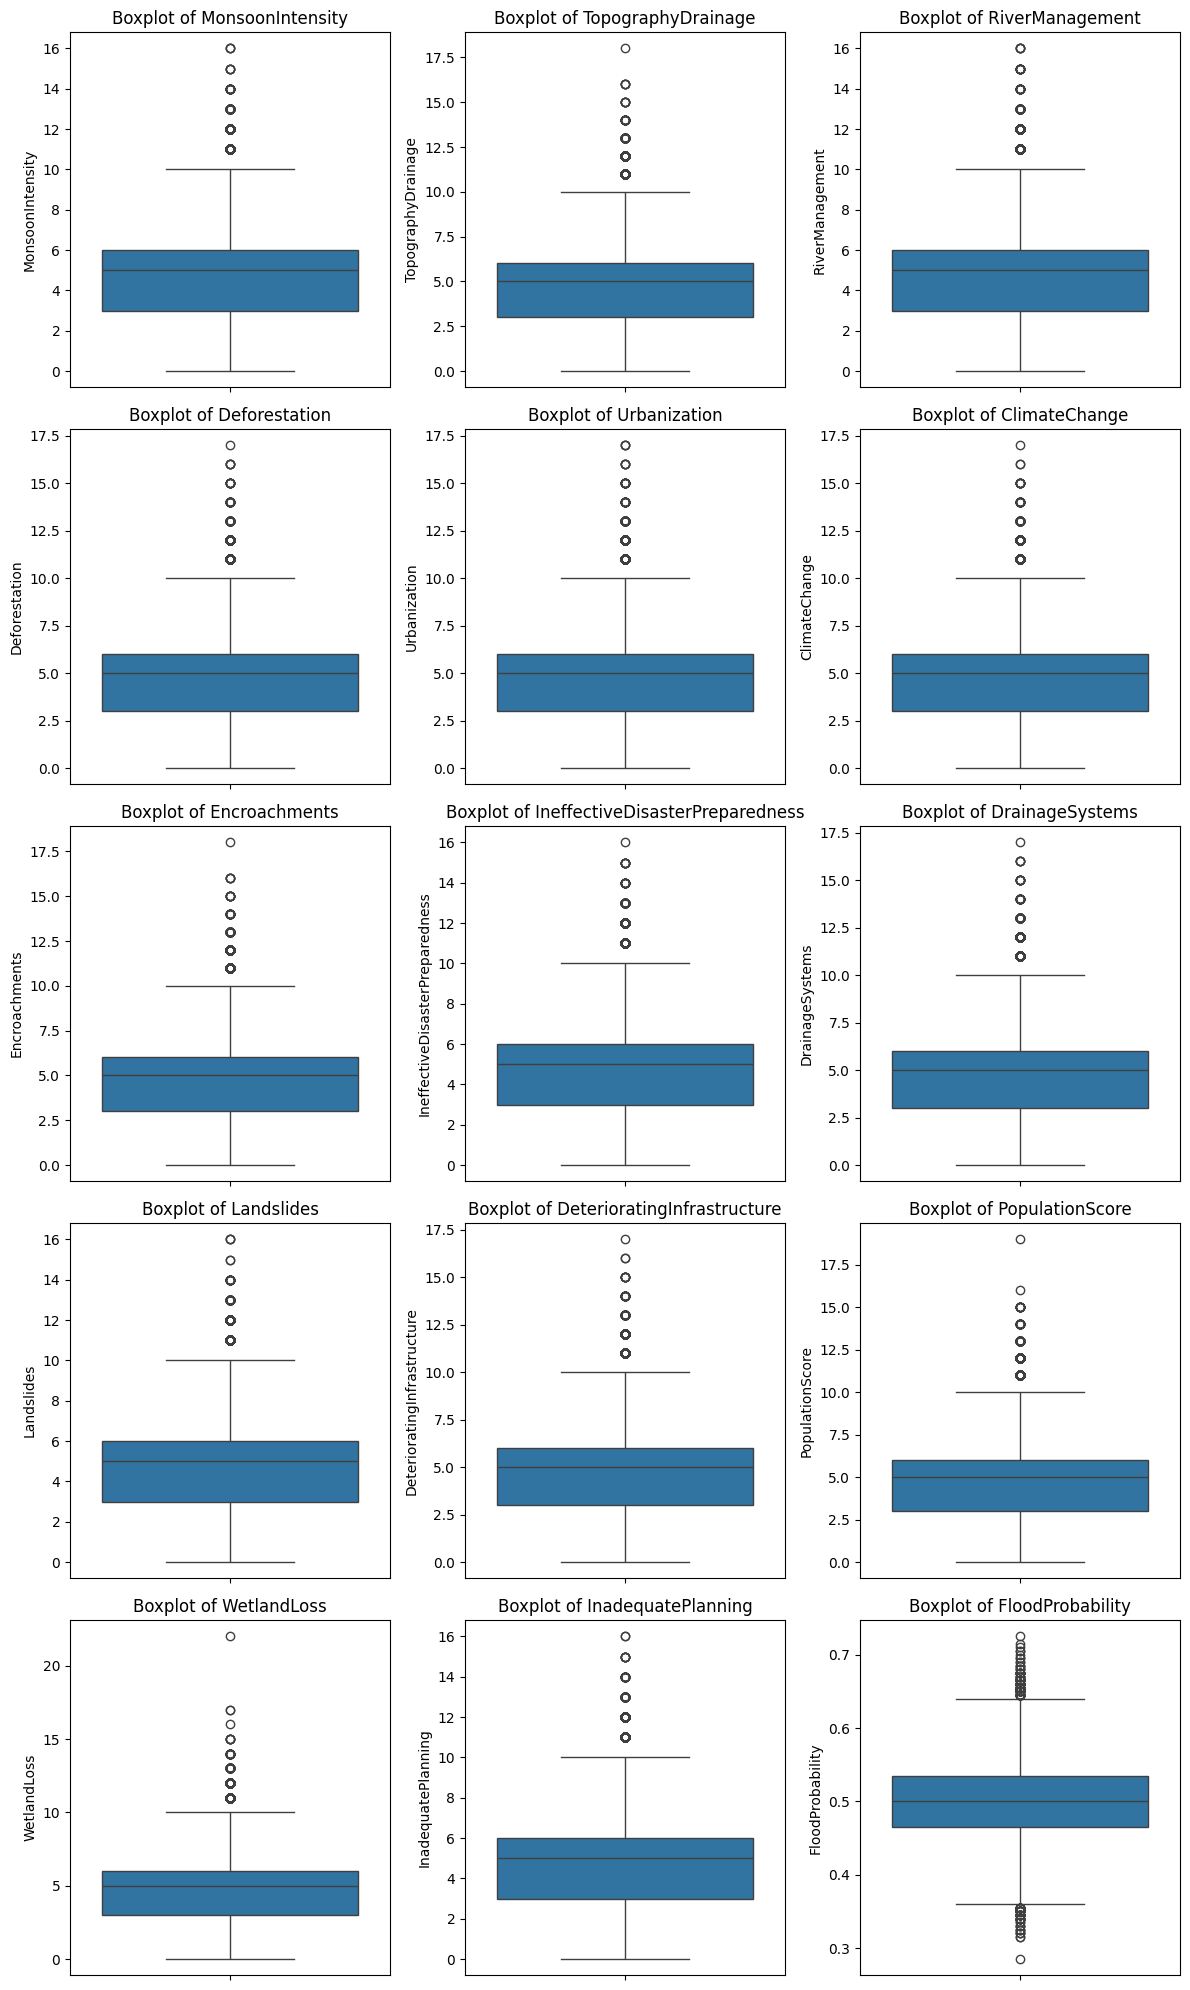

In [27]:
# Plot boxplots for numeric columns to detect outliers
plt.figure(figsize=(12, 4 * n_rows))  # Adjust height based on number of rows
for i, column in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

In [28]:
# Remove outliers using Z-score method
z_scores = np.abs(stats.zscore(data[numeric_columns]))
data = data[(z_scores < 3).all(axis=1)]  # Keep rows where all Z-scores are less than 3
print("\nDataset after removing outliers:")
print(data.shape)


Dataset after removing outliers:
(46287, 16)


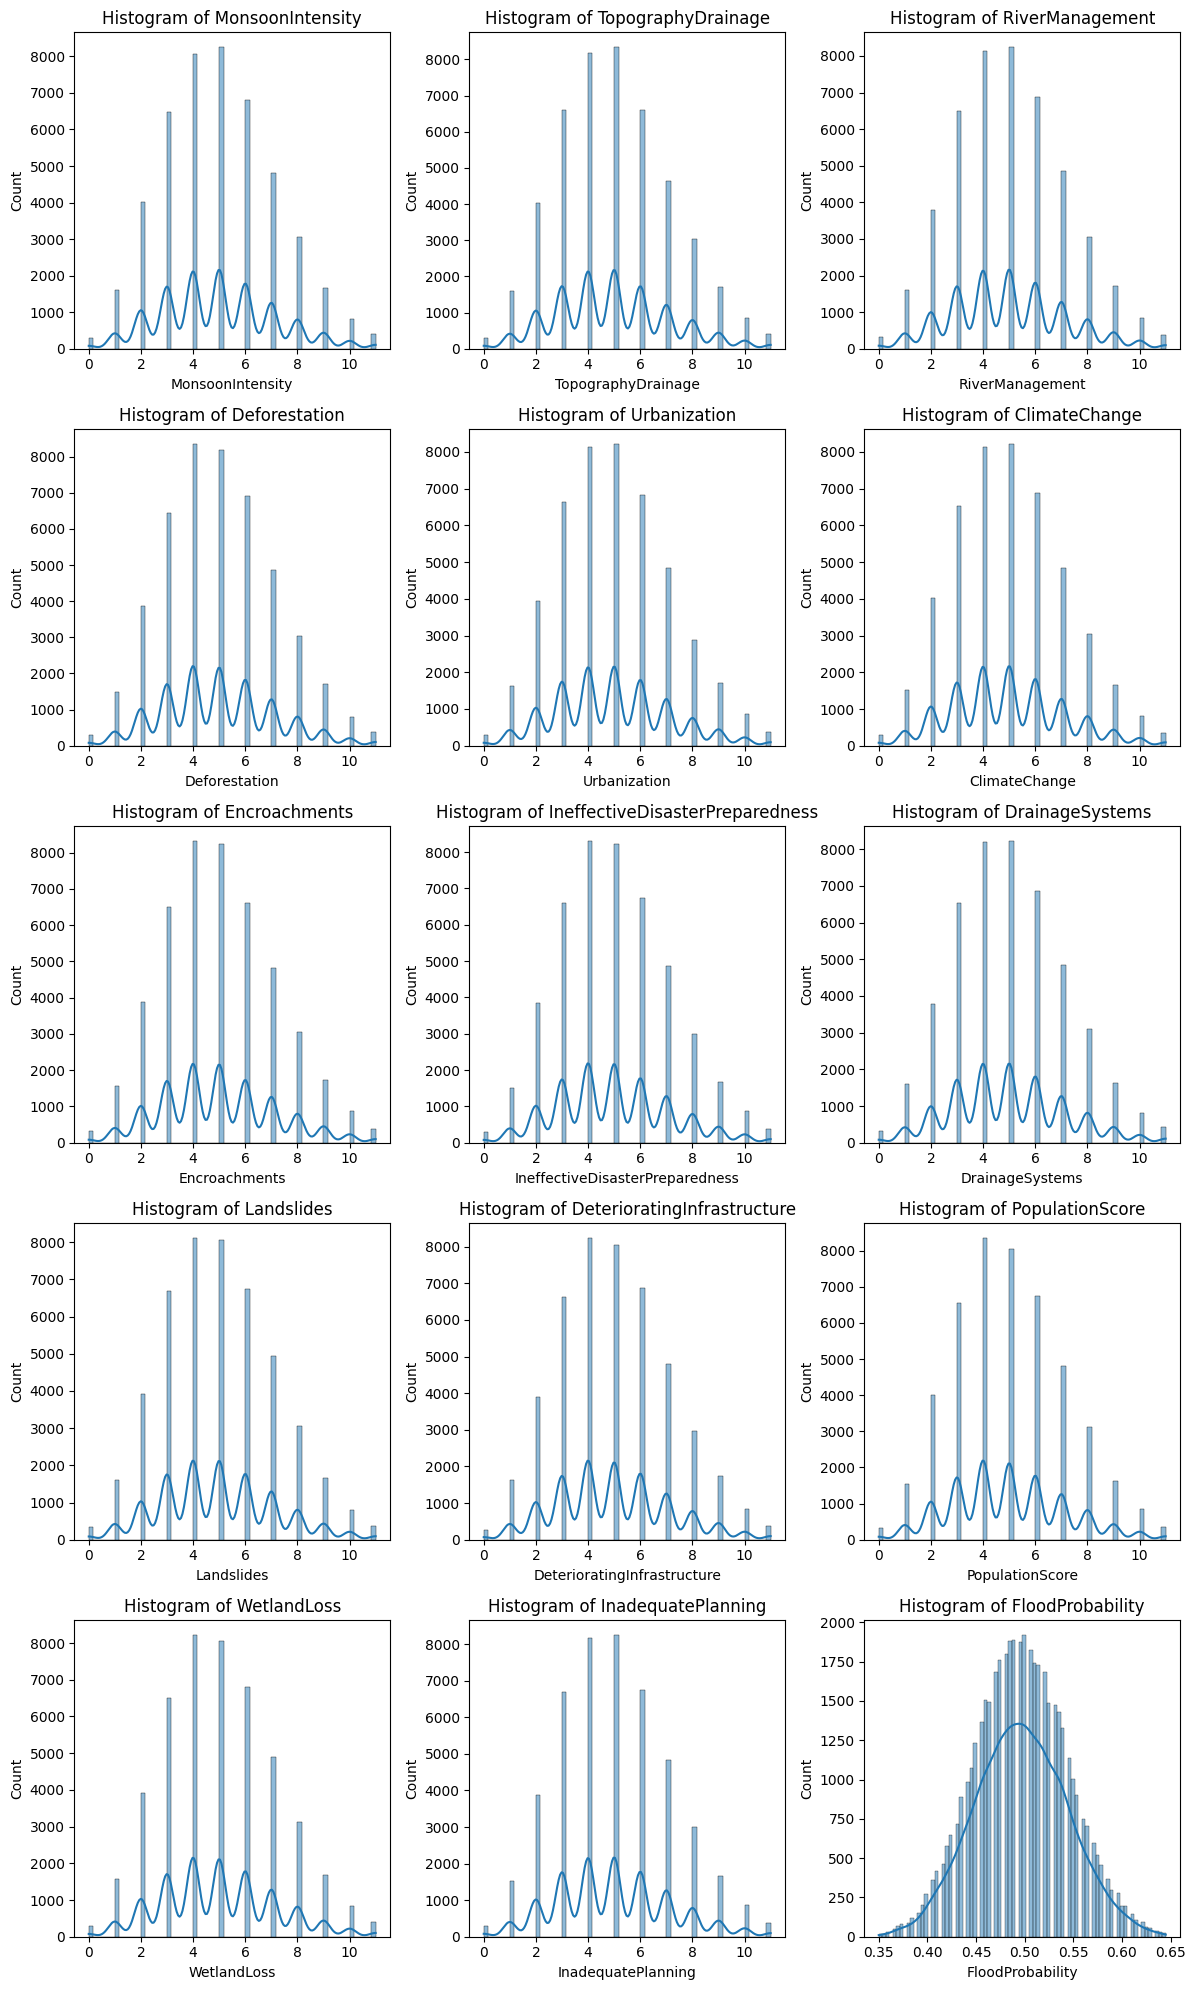

In [29]:
# Plot histograms for numeric columns after removing outliers
n_cols = 3  # You can set this to any number you prefer
n_rows = int(np.ceil(len(numeric_columns) / n_cols))  # Calculate the number of rows

plt.figure(figsize=(12, 4 * n_rows))  # Adjust height based on number of rows
for i, column in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
plt.tight_layout()
plt.show()

In [30]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [31]:
# Create directory to save models
saved_models_dir = 'saved_models'
os.makedirs(saved_models_dir, exist_ok=True)

In [32]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

In [33]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum samples required to split a node
}

In [34]:
# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [35]:
# Best model
best_rf = grid_search_rf.best_estimator_

In [36]:
# Save the Random Forest model
rf_model_path = os.path.join(saved_models_dir, 'random_forest_model.pkl')
joblib.dump(best_rf, rf_model_path)

['saved_models/random_forest_model.pkl']

In [37]:
# Predictions
y_pred_rf = best_rf.predict(X_val)

In [38]:
# Accuracy and classification report
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print("Classification Report:\n", classification_report(y_val, y_pred_rf))
print(f"Best Hyperparameters: {grid_search_rf.best_params_}")

Random Forest Accuracy: 0.9548
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       227
           1       1.00      0.00      0.01       227
           2       0.95      1.00      0.98      9546

    accuracy                           0.95     10000
   macro avg       0.98      0.34      0.33     10000
weighted avg       0.96      0.95      0.93     10000

Best Hyperparameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}


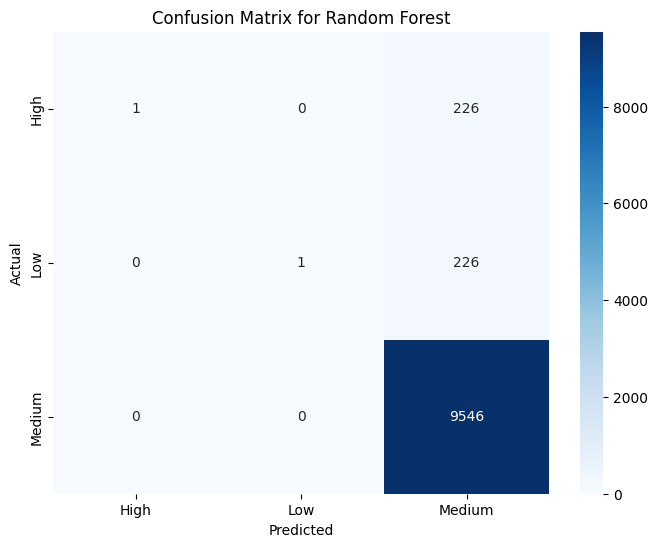

In [39]:
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

In [41]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2]  # Step size shrinkage
}

In [42]:
# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search_xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:43:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:43:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:43:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:43:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [43]:
# Best model
best_xgb = grid_search_xgb.best_estimator_

In [44]:
# Save the XGBoost model
xgb_model_path = os.path.join(saved_models_dir, 'xgboost_model.pkl')
joblib.dump(best_xgb, xgb_model_path)

['saved_models/xgboost_model.pkl']

In [45]:
# Predictions
y_pred_xgb = best_xgb.predict(X_val)

In [46]:
# Accuracy and classification report
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")
print("Classification Report:\n", classification_report(y_val, y_pred_xgb))
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")

XGBoost Accuracy: 0.9567
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.16      0.25       227
           1       0.60      0.15      0.24       227
           2       0.96      0.99      0.98      9546

    accuracy                           0.96     10000
   macro avg       0.71      0.43      0.49     10000
weighted avg       0.94      0.96      0.94     10000

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


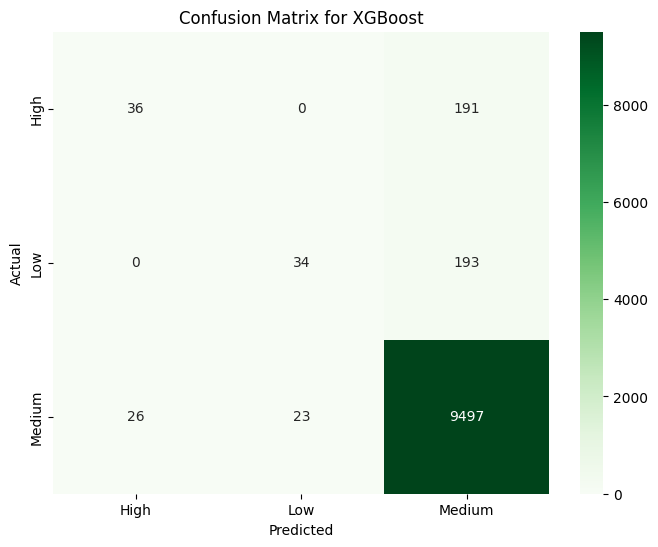

In [47]:
# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
# Neural Network Implementation
def create_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.0, regularization=0.0, num_layers=3):
    model = Sequential()

    # Input layer
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(regularization), input_shape=(X_train.shape[1],)))

    # Hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(regularization)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for FloodRisk

    # Compile the model
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [49]:
# Call the model function with different optimization techniques
model1 = create_model()
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9363 - loss: 0.2431 - val_accuracy: 0.9554 - val_loss: 0.1261
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9562 - loss: 0.1249 - val_accuracy: 0.9551 - val_loss: 0.1247
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9596 - loss: 0.1120 - val_accuracy: 0.9566 - val_loss: 0.1203
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9606 - loss: 0.1098 - val_accuracy: 0.9561 - val_loss: 0.1258
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9580 - loss: 0.1114 - val_accuracy: 0.9580 - val_loss: 0.1204
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9630 - loss: 0.1048 - val_accuracy: 0.9571 - val_loss: 0.1214
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9618 - loss: 0.1037 - val_accuracy: 0.9569 - val_loss: 0.1227
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9622 - loss: 0.1053 - val_accuracy: 0.

In [50]:
# Save Model 1
model1_path = os.path.join(saved_models_dir, 'neural_network_model1.h5')
model1.save(model1_path)

In [51]:
model2 = create_model(learning_rate=0.01)
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9490 - loss: 0.1829 - val_accuracy: 0.9545 - val_loss: 0.1325
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9561 - loss: 0.1229 - val_accuracy: 0.9579 - val_loss: 0.1208
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9582 - loss: 0.1190 - val_accuracy: 0.9559 - val_loss: 0.1202
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9583 - loss: 0.1149 - val_accuracy: 0.9574 - val_loss: 0.1202
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9549 - loss: 0.1212 - val_accuracy: 0.9561 - val_loss: 0.1229
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9578 - loss: 0.1151 - val_accuracy: 0.9526 - val_loss: 0.1244
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9580 - loss: 0.1187 - val_accuracy: 0.9541 - val_loss: 0.1237
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9558 - loss: 0.1243 - val_accuracy: 0.

In [52]:
# Save Model 2
model2_path = os.path.join(saved_models_dir, 'neural_network_model2.h5')
model2.save(model2_path)

In [53]:
model3 = create_model(dropout_rate=0.2)
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9496 - loss: 0.2307 - val_accuracy: 0.9540 - val_loss: 0.1301
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9564 - loss: 0.1256 - val_accuracy: 0.9557 - val_loss: 0.1274
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9560 - loss: 0.1213 - val_accuracy: 0.9558 - val_loss: 0.1245
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9571 - loss: 0.1161 - val_accuracy: 0.9560 - val_loss: 0.1212
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9580 - loss: 0.1158 - val_accuracy: 0.9563 - val_loss: 0.1249
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9588 - loss: 0.1129 - val_accuracy: 0.9569 - val_loss: 0.1228
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9588 - loss: 0.1122 - val_accuracy: 0.9563 - val_loss: 0.1240
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9594 - loss: 0.1096 - val_accuracy: 0.

In [54]:
# Save Model 3
model3_path = os.path.join(saved_models_dir, 'neural_network_model3.h5')
model3.save(model3_path)

In [55]:
model4 = create_model(regularization=0.01)
history4 = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9454 - loss: 0.8180 - val_accuracy: 0.9573 - val_loss: 0.1868
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9570 - loss: 0.1764 - val_accuracy: 0.9579 - val_loss: 0.1651
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9598 - loss: 0.1582 - val_accuracy: 0.9575 - val_loss: 0.1564
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9595 - loss: 0.1517 - val_accuracy: 0.9543 - val_loss: 0.1649
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9615 - loss: 0.1462 - val_accuracy: 0.9577 - val_loss: 0.1523
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9598 - loss: 0.1471 - val_accuracy: 0.9575 - val_loss: 0.1481
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9597 - loss: 0.1467 - val_accuracy: 0.9586 - val_loss: 0.1455
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9605 - loss: 0.1439 - val_accuracy: 0.

In [56]:
# Save Model 4
model4_path = os.path.join(saved_models_dir, 'neural_network_model4.h5')
model4.save(model4_path)

In [57]:
model5 = create_model(num_layers=4)
history5 = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9353 - loss: 0.2439 - val_accuracy: 0.9553 - val_loss: 0.1409
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9600 - loss: 0.1145 - val_accuracy: 0.9574 - val_loss: 0.1193
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9593 - loss: 0.1151 - val_accuracy: 0.9564 - val_loss: 0.1207
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9584 - loss: 0.1128 - val_accuracy: 0.9563 - val_loss: 0.1196
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9607 - loss: 0.1073 - val_accuracy: 0.9554 - val_loss: 0.1247
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9608 - loss: 0.1049 - val_accuracy: 0.9553 - val_loss: 0.1209
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9606 - loss: 0.1073 - val_accuracy: 0.9560 - val_loss: 0.1236
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9628 - loss: 0.1003 - val_accuracy: 0.

In [58]:
# Save Model 5
model5_path = os.path.join(saved_models_dir, 'neural_network_model5.h5')
model5.save(model5_path)

In [59]:
# Evaluate the models
results_nn = {
    'Model': ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'],
    'Accuracy': []
}

for model in [model1, model2, model3, model4, model5]:
    loss, accuracy = model.evaluate(X_val, y_val)
    results_nn['Accuracy'].append(accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9557 - loss: 0.1212
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9566 - loss: 0.1384
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9578 - loss: 0.1210
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9564 - loss: 0.1457
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9513 - loss: 0.1336


In [60]:
# Create a DataFrame to display results
results_nn_df = pd.DataFrame(results_nn)
print("\nNeural Network Results:")
print(results_nn_df)


Neural Network Results:
     Model  Accuracy
0  Model 1    0.9566
1  Model 2    0.9554
2  Model 3    0.9567
3  Model 4    0.9565
4  Model 5    0.9529


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


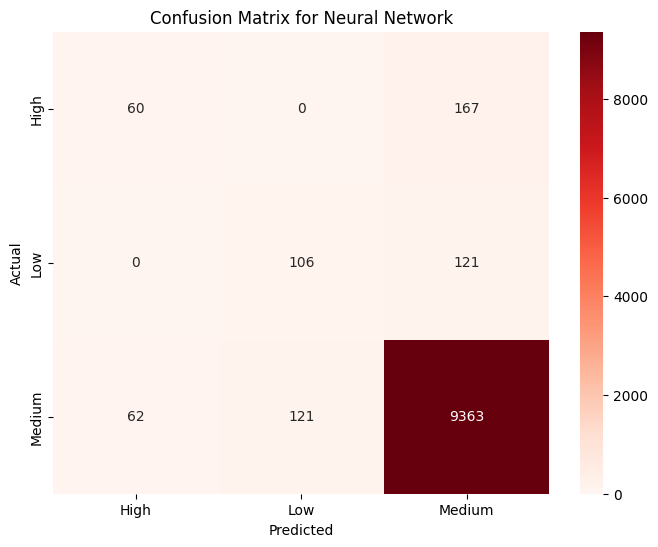

In [61]:
# Confusion Matrix for the Best Neural Network Model
best_nn_model = model5  # Replace with the best model
y_pred_nn = best_nn_model.predict(X_val)
y_pred_nn = np.argmax(y_pred_nn, axis=1)

conf_matrix_nn = confusion_matrix(y_val, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [62]:
# Print where models are saved
print(f"Models saved in {saved_models_dir}")

Models saved in saved_models


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


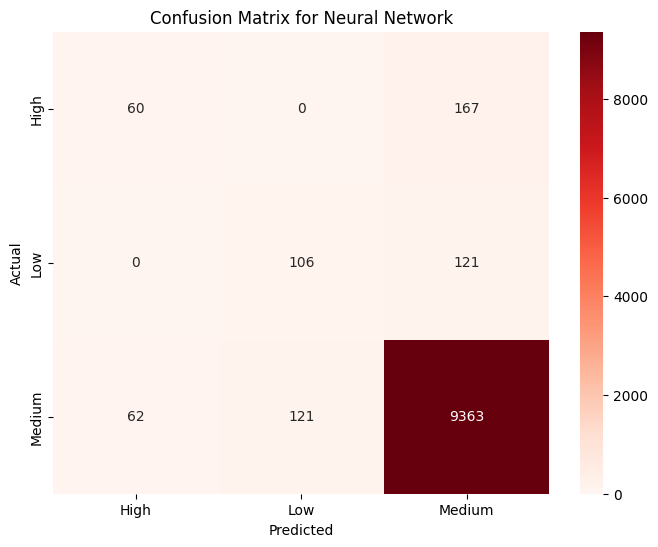

In [63]:
# Confusion Matrix for the Best Neural Network Model
best_nn_model = model5  # Replace with the best model
y_pred_nn = best_nn_model.predict(X_val)
y_pred_nn = np.argmax(y_pred_nn, axis=1)

conf_matrix_nn = confusion_matrix(y_val, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()